Problem Senaryosu: Telekomünikasyon Şirketi Müşteri Kaybı (Churn) Tahmini

Problemin Tanımı:

Bir telekomünikasyon şirketi olan "X", son zamanlarda artan müşteri kaybından (churn) şikayetçidir. Şirket, hangi müşterilerin aboneliklerini iptal etme olasılığının yüksek olduğunu önceden tahmin etmek istiyor. Bu sayede, risk altındaki müşterilere özel indirimler, kampanyalar veya daha iyi hizmetler sunarak onları elde tutmayı hedefliyorlar.

Öğrencilerden Beklenen Görev:

Öğrencilere verilecek olan "X" müşteri veri setini kullanarak, bir müşterinin şirketi terk edip etmeyeceğini (Churn_Durumu) tahmin eden bir makine öğrenmesi modeli geliştirmeleri istenmektedir. En yüksek doğrulukla tahmin yapan modeli geliştiren ekip/öğrenci başarılı sayılacaktır.

In [2]:
import pandas as pd #veri okuma ve işlemi için.
import numpy as np #sayısal işlemler için .
import seaborn as sns # gelişmiş görselleştirme için.
import matplotlib.pyplot as plt #görselleştirme
import datetime # aşağıda bu son aktif tarihi bugunden çıkarıp kullanım zamanına bakcam


In [3]:
# BUNLARI YÜKLEMENİN AMACI DA VERİ ANALİZİ YA DA MAKİNE ÖĞRENİMİ İÇİN. 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report , mean_squared_error

In [4]:
df = pd.read_csv("Veri.csv")

In [5]:
df.columns.tolist()

['MusteriID',
 'Cinsiyet',
 'Yas',
 'AbonelikSuresi_Ay',
 'AylikUcret',
 'TeknikDestekAramalari',
 'KullanilanServisler',
 'SonAktiviteTarihi',
 'Churn_Durumu',
 'ToplamHarcananTutar']

In [6]:
df.info()
# 3 TANE SIKINTI VAR 
# 1. AYLIKUCRET NEDEN OBJEEE 
#2.TARİH KISMI DATATİME OLCAKK
#3.TOPLAM HARCANAN TUTAR OBJ OLMAMALI SAYI O İNT OLMALI

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   MusteriID              100000 non-null  object 
 1   Cinsiyet               95938 non-null   object 
 2   Yas                    95000 non-null   float64
 3   AbonelikSuresi_Ay      100000 non-null  int64  
 4   AylikUcret             95000 non-null   object 
 5   TeknikDestekAramalari  100000 non-null  int64  
 6   KullanilanServisler    100000 non-null  object 
 7   SonAktiviteTarihi      100000 non-null  object 
 8   Churn_Durumu           100000 non-null  object 
 9   ToplamHarcananTutar    92289 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


In [7]:
df["AylikUcret"]= pd.to_numeric(df["AylikUcret"],errors="coerce")

In [8]:
df["SonAktiviteTarihi"] = pd.to_datetime(df["SonAktiviteTarihi"] , errors="coerce")

In [9]:
df["ToplamHarcananTutar"]= pd.to_numeric(df["ToplamHarcananTutar"], errors="coerce")

In [10]:
# önce boş değerlerimize bakalım
df.isnull().sum().sort_values(ascending=False)

ToplamHarcananTutar      10503
AylikUcret                9741
Yas                       5000
Cinsiyet                  4062
MusteriID                    0
AbonelikSuresi_Ay            0
TeknikDestekAramalari        0
KullanilanServisler          0
SonAktiviteTarihi            0
Churn_Durumu                 0
dtype: int64

In [11]:
#şimdi doldurmadan önce bi bu cinsiyetteki SIKINTIYI halledelim bu k ve e mevzusu
df["Cinsiyet"].unique()

array(['Kadın', 'Erkek', 'K', 'E', nan], dtype=object)

In [12]:
df["Cinsiyet"] = df["Cinsiyet"].replace({"K": "Kadın", "E": "Erkek"})

In [13]:
#kontrol yapıyoz bakalım
df["Cinsiyet"].unique()
# şimdide nan çıktı onları oldurucaz ben mode ile doldurmak istiyorum sebebi yok

array(['Kadın', 'Erkek', nan], dtype=object)

In [14]:
cinsiyet_mod = df["Cinsiyet"].mode()[0]
df["Cinsiyet"]= df["Cinsiyet"].fillna(cinsiyet_mod)
df["Cinsiyet"].isnull().sum() #tamamdurrr.

np.int64(0)

<Axes: xlabel='Yas', ylabel='Count'>

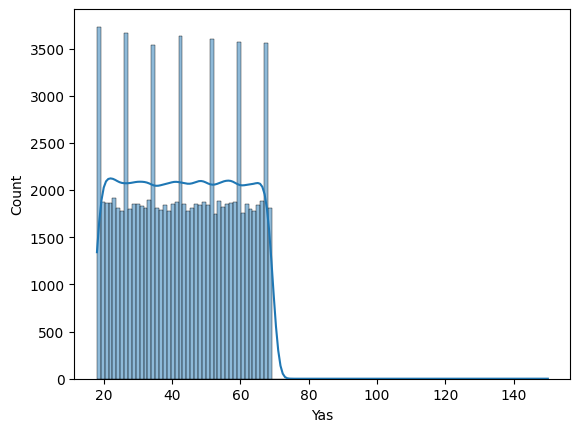

In [15]:
# yas colonun da da boşluk baya var onu da median ile dolduracağım.
# neye göre dolduracğımı da öğrendim dağılama bakıcaz eğer dağılım 
# simetrikse mean , dağılım tek tarfa kayıksa median , sadece bir kaç değer çok sık tekar ediyorda mod

sns.histplot(df["Yas"], kde=True)

# bu sonuca göre benim median ile dolduracağım belli yerlerde pik var aykırı çok yok

In [16]:
df["Yas"].describe()

count    95000.000000
mean        43.411526
std         15.031309
min         18.000000
25%         30.000000
50%         43.000000
75%         56.000000
max        150.000000
Name: Yas, dtype: float64

In [17]:
yas_median = df["Yas"].median()
df["Yas"] = df["Yas"].fillna(yas_median)

<Axes: xlabel='AylikUcret', ylabel='Count'>

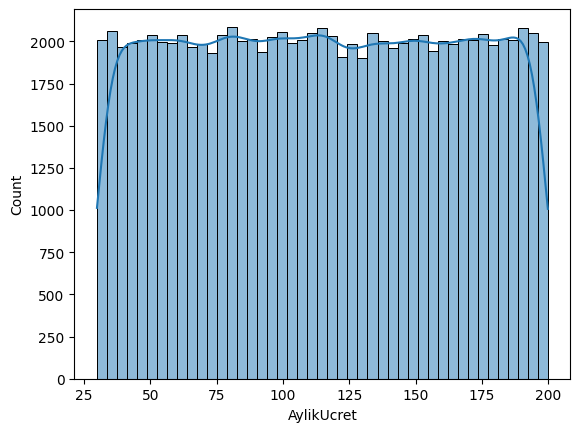

In [18]:
#şimdi aynı olayı aylıkucrette denicez 
sns.histplot(df["AylikUcret"] , kde= True)
# mesela bunda da mean ile doldurmak daha mantıklı aşırı simetrik bu ne

In [19]:
aylıkucret_mean = df["AylikUcret"].mean()
df["AylikUcret"]= df["AylikUcret"].fillna(aylıkucret_mean)

<Axes: xlabel='ToplamHarcananTutar', ylabel='Count'>

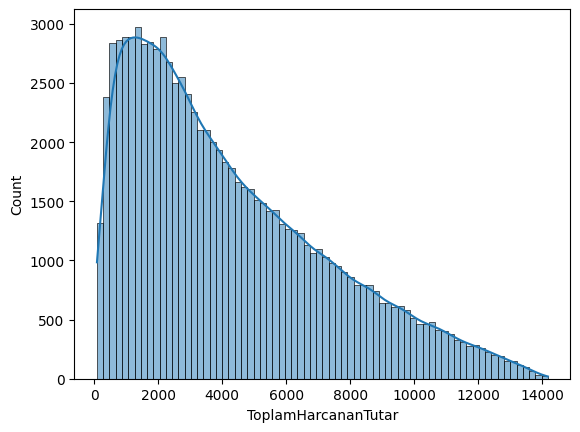

In [20]:
# toplamharcanantutar için bakıcaz 
sns.histplot(df["ToplamHarcananTutar"], kde= True)
# belli yani medianla doldur kanka

In [21]:
toplamharcanantutar_median = df["ToplamHarcananTutar"].median()
df["ToplamHarcananTutar"]=df["ToplamHarcananTutar"].fillna(toplamharcanantutar_median)

BOŞLUKLAR DOLDUUUUUUUUUU

In [22]:
#  bu ıd sayısının olduğu colonu atmak istiyorum
df.drop("MusteriID" , axis= 1 ,inplace= True)

In [23]:
df.head()

,Cinsiyet,Yas,AbonelikSuresi_Ay,AylikUcret,TeknikDestekAramalari,KullanilanServisler,SonAktiviteTarihi,Churn_Durumu,ToplamHarcananTutar
0,Kadın,54.0,50,31.70,9,"Mobil,TV,Telefon",2024-09-29,Evet,1585.00
1,Kadın,20.0,12,111.35,5,"Internet,Mobil",2024-11-28,Hayır,1336.20
2,Erkek,67.0,33,113.99,5,Mobil,2025-02-01,Hayır,3761.67
3,Kadın,64.0,2,79.10,6,"Internet,Mobil",2024-08-24,Hayır,3485.56
4,Kadın,59.0,53,88.53,8,"Mobil,Internet",2025-04-09,Hayır,4692.09


In [24]:
df["Churn_Durumu"]= df["Churn_Durumu"].replace({"Evet":1 , "Hayır":0}).astype(int)
# astype yapmanın nedeni makine öğrenimi için 0 ve 1 değerlerini int yaptı

C:\Users\dell\AppData\Local\Temp\ipykernel_3264\1928658410.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn_Durumu"]= df["Churn_Durumu"].replace({"Evet":1 , "Hayır":0}).astype(int)


# TAMAM SON DUZENLEMELERRDE YAPILDI VERİ DAHA DUZGUN ARTIKKKK

şimdide bu yas sutunundan yola çıkarak genç yetişkin yaşlı ve ultrayaşlı(150 vardı ama bilemiyorum belki onu atarım)

In [25]:
print(df.columns)
df.columns = df.columns.str.strip()

Index(['Cinsiyet', 'Yas', 'AbonelikSuresi_Ay', 'AylikUcret',
       'TeknikDestekAramalari', 'KullanilanServisler', 'SonAktiviteTarihi',
       'Churn_Durumu', 'ToplamHarcananTutar'],
      dtype='object')


In [26]:
df["Yas"].describe()

count    100000.000000
mean         43.390950
std          14.650979
min          18.000000
25%          31.000000
50%          43.000000
75%          56.000000
max         150.000000
Name: Yas, dtype: float64

In [27]:
df = df[df["Yas"]<100] # bu cod ile 150 yi attık çok aykırı

In [28]:
# şimdi genç,yetişkin,yaslı olayını pd.cut yapmıcam bildiğim yoldan gidicem
def yas_gruplandır(Yas):
    if Yas<25:
        return "genç"
    elif Yas<60:
        return "yetişkin"
    else:
        return "yaşlı"
    
df["yas_grubu"]= df['Yas'].apply(yas_gruplandır)  

In [29]:
df.head()
#OLDUUUUUUUUU

,Cinsiyet,Yas,AbonelikSuresi_Ay,AylikUcret,TeknikDestekAramalari,KullanilanServisler,SonAktiviteTarihi,Churn_Durumu,ToplamHarcananTutar,yas_grubu
0,Kadın,54.0,50,31.70,9,"Mobil,TV,Telefon",2024-09-29,1,1585.00,yetişkin
1,Kadın,20.0,12,111.35,5,"Internet,Mobil",2024-11-28,0,1336.20,genç
2,Erkek,67.0,33,113.99,5,Mobil,2025-02-01,0,3761.67,yaşlı
3,Kadın,64.0,2,79.10,6,"Internet,Mobil",2024-08-24,0,3485.56,yaşlı
4,Kadın,59.0,53,88.53,8,"Mobil,Internet",2025-04-09,0,4692.09,yetişkin


In [30]:
print(f"cinsiyete göre iptal yuzdeleri :", df.groupby("Cinsiyet")["Churn_Durumu"].mean()*100)

cinsiyete göre iptal yuzdeleri : Cinsiyet
Erkek    24.807890
Kadın    25.380934
Name: Churn_Durumu, dtype: float64


çok da etkili değil bu durum

In [31]:
df.groupby("Churn_Durumu")[["Yas","AbonelikSuresi_Ay","ToplamHarcananTutar"]].mean()

,Yas,AbonelikSuresi_Ay,ToplamHarcananTutar
Churn_Durumu,,,
0,43.398774,35.934706,4167.347600
1,43.363365,35.730991,4151.748422


bunlarda etkili değil

In [32]:
df.corr(numeric_only=True)['Churn_Durumu'].sort_values(ascending=False)
# yok ilişki bunlarla

Churn_Durumu             1.000000
AylikUcret              -0.000846
Yas                     -0.001048
ToplamHarcananTutar     -0.002310
AbonelikSuresi_Ay       -0.004311
TeknikDestekAramalari   -0.007558
Name: Churn_Durumu, dtype: float64

<Axes: xlabel='Churn_Durumu', ylabel='count'>

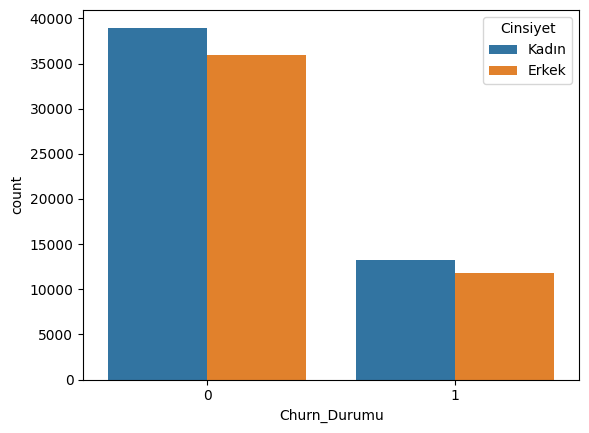

In [33]:
sns.countplot(x='Churn_Durumu', hue='Cinsiyet', data=df)
# yani al bak etkili değil işte

# sns.countplot(x="Churn_Durumu", hue="KullanilanServisler", data=df )

# bu  ÇOK KARIŞIK BU SADELEŞTİRMEM LAZIMMMM 

In [34]:
df["tv_var"]=df["KullanilanServisler"].str.contains("TV").astype(int)
df["internet_var"]=df["KullanilanServisler"].str.contains("İnternet").astype(int)
df["mobil_var"]=df["KullanilanServisler"].str.contains("Mobil").astype(int)
df["telefon_var"]=df["KullanilanServisler"].str.contains("Telefon").astype(int)


In [35]:
df['tv_var'] = df['KullanilanServisler'].str.contains('tv', case=False).astype(int)
df['internet_var'] = df['KullanilanServisler'].str.contains('internet', case=False).astype(int)
df['telefon_var'] = df['KullanilanServisler'].str.contains('telefon', case=False).astype(int)

In [36]:
#pd.crosstab(df['KullanilanServisler'], df['Churn_Durumu'], normalize='index')
# bu colonu silemem etkiliyormuş iptali 

In [37]:
df= df.drop("KullanilanServisler", axis=1)

In [38]:
df.head()

,Cinsiyet,Yas,AbonelikSuresi_Ay,AylikUcret,TeknikDestekAramalari,SonAktiviteTarihi,Churn_Durumu,ToplamHarcananTutar,yas_grubu,tv_var,internet_var,mobil_var,telefon_var
0,Kadın,54.0,50,31.70,9,2024-09-29,1,1585.00,yetişkin,1,0,1,1
1,Kadın,20.0,12,111.35,5,2024-11-28,0,1336.20,genç,0,1,1,0
2,Erkek,67.0,33,113.99,5,2025-02-01,0,3761.67,yaşlı,0,0,1,0
3,Kadın,64.0,2,79.10,6,2024-08-24,0,3485.56,yaşlı,0,1,1,0
4,Kadın,59.0,53,88.53,8,2025-04-09,0,4692.09,yetişkin,0,1,1,0


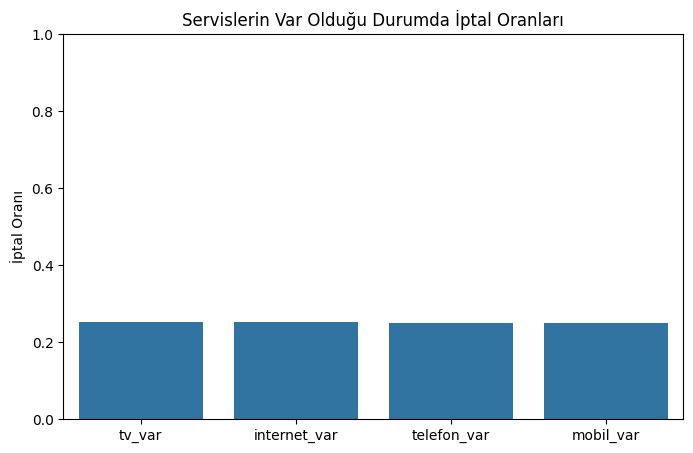

In [39]:
servisler = ['tv_var', 'internet_var', 'telefon_var','mobil_var']
iptal_oranlari = []

for servis in servisler:
    oran = df[df[servis] == 1]['Churn_Durumu'].mean()
    iptal_oranlari.append(oran)

plt.figure(figsize=(8,5))
sns.barplot(x=servisler, y=iptal_oranlari)
plt.ylim(0, 1)
plt.ylabel('İptal Oranı')
plt.title('Servislerin Var Olduğu Durumda İptal Oranları')
plt.show()


bu servislerinde iptal lere çok etkisi yok demek

In [40]:
df.groupby("Churn_Durumu")[["AylikUcret","ToplamHarcananTutar"]].mean()

,AylikUcret,ToplamHarcananTutar
Churn_Durumu,,
0,114.951232,4167.347600
1,114.860123,4151.748422


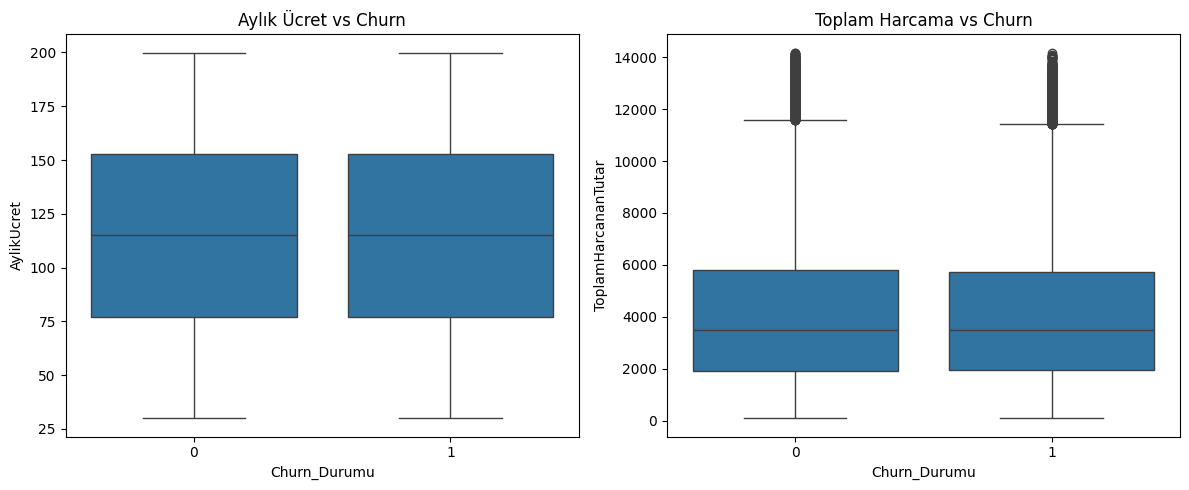

In [41]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.boxplot(x='Churn_Durumu', y='AylikUcret', data=df)
plt.title('Aylık Ücret vs Churn')

plt.subplot(1, 2, 2)
sns.boxplot(x='Churn_Durumu', y='ToplamHarcananTutar', data=df)
plt.title('Toplam Harcama vs Churn')

plt.tight_layout()
plt.show()


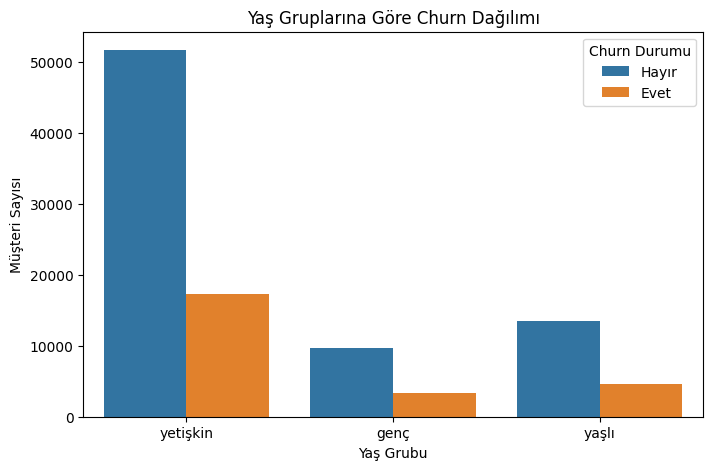

In [42]:
plt.figure(figsize=(8,5))
sns.countplot(x='yas_grubu', hue='Churn_Durumu', data=df)
plt.title('Yaş Gruplarına Göre Churn Dağılımı')
plt.xlabel('Yaş Grubu')
plt.ylabel('Müşteri Sayısı')
plt.legend(title='Churn Durumu', labels=['Hayır', 'Evet'])
plt.show()

#YETİŞKİNLER DAHA ÇOK İPTAL ETMİŞ sorunlular yani ne diyim

In [43]:
df.groupby("yas_grubu")[["AylikUcret","ToplamHarcananTutar"]].mean()

,AylikUcret,ToplamHarcananTutar
yas_grubu,,
genç,114.910198,4169.270274
yaşlı,115.056976,4133.105329
yetişkin,114.897996,4170.293786


In [44]:
df[df["yas_grubu"]== "yetişkin"]

,Cinsiyet,Yas,AbonelikSuresi_Ay,AylikUcret,TeknikDestekAramalari,SonAktiviteTarihi,Churn_Durumu,ToplamHarcananTutar,yas_grubu,tv_var,internet_var,mobil_var,telefon_var
0,Kadın,54.0,50,31.70,9,2024-09-29,1,1585.00,yetişkin,1,0,1,1
4,Kadın,59.0,53,88.53,8,2025-04-09,0,4692.09,yetişkin,0,1,1,0
5,Kadın,43.0,12,118.02,3,2024-11-12,0,1416.24,yetişkin,1,0,1,0
6,Erkek,27.0,60,187.96,6,2025-01-14,0,11277.60,yetişkin,1,0,1,0
8,Erkek,48.0,42,165.52,9,2025-02-25,0,6951.84,yetişkin,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,Kadın,43.0,66,159.92,5,2025-07-09,0,10554.72,yetişkin,1,0,0,1
99993,Kadın,47.0,3,84.15,9,2025-04-27,0,252.45,yetişkin,1,0,0,0
99995,Erkek,44.0,23,82.70,9,2025-06-12,0,1902.10,yetişkin,1,0,0,0
99998,Kadın,46.0,51,147.19,6,2025-02-04,0,7506.69,yetişkin,1,0,1,1


In [45]:
df.groupby('yas_grubu')[['tv_var', 'internet_var', 'telefon_var','mobil_var']].mean()

,tv_var,internet_var,telefon_var,mobil_var
yas_grubu,,,,
genç,0.502028,0.499885,0.494759,0.491927
yaşlı,0.494529,0.500276,0.501271,0.496684
yetişkin,0.497923,0.499608,0.501337,0.502179


In [46]:
bugun = pd.to_datetime(datetime.date.today())

In [47]:
df['aktifolmama_suresi'] = (bugun - df['SonAktiviteTarihi']).dt.days


Text(0.5, 1.0, 'Abonelik Süresi ile Churn İlişkisi')

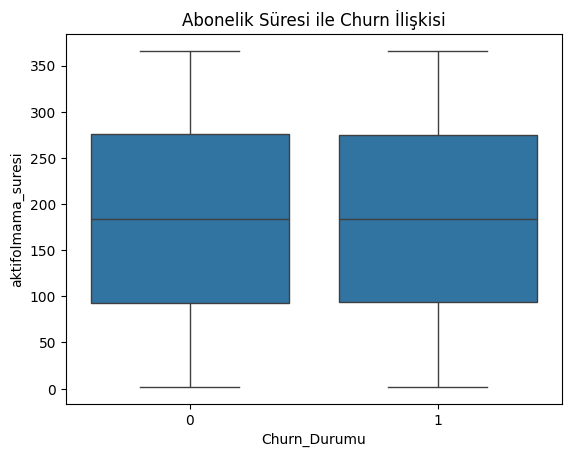

In [48]:
sns.boxplot(x='Churn_Durumu', y='aktifolmama_suresi', data=df)
plt.title('Abonelik Süresi ile Churn İlişkisi')

In [49]:
df_model = df.copy()
df_model['yas_grubu'] = df_model['yas_grubu'].astype(str)
df_model = pd.get_dummies(df_model, columns=['yas_grubu'], drop_first=True)

In [50]:
X = df_model[['AylikUcret', 'ToplamHarcananTutar', 'tv_var', 'internet_var', 'telefon_var'
              ]]
y = df_model['Churn_Durumu']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modeli eğit
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Tahminler
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

# Performans raporu
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     22524
           1       0.00      0.00      0.00      7476

    accuracy                           0.75     30000
   macro avg       0.38      0.50      0.43     30000
weighted avg       0.56      0.75      0.64     30000



c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag